## Roteiro: map matching na prática
Vamos caminhar pelas etapas de alinhamento de trajetórias GPS no entorno do aeroporto O'Hare usando GraphHopper via `mmlib`: preparar dados, rodar o matcher e conferir o resultado contra a verdade-terreno.

In [58]:
import pandas as pd

from pathlib import Path

### 1) Definir caminhos-base
Apontamos para a raiz do projeto e para onde ficam os dados (`data/`) e artefatos (`networks/`). Isso mantém os próximos passos reproduzíveis.

In [59]:
ROOT_PATH = Path(".").resolve().absolute()
DATA_PATH = ROOT_PATH / "data"
VEHICLE_ID = 1450
SAMPLE_RATE_SECONDS: int | None = 2
GRAPHHOPPER_URL = "http://localhost:8989"

### 2) Carregar datasets com DuckDB
Usamos uma função auxiliar com DuckDB para ler Parquets em DataFrames pandas de forma rápida e sem dependências externas adicionais.

In [60]:
import duckdb

def load_dataset(path: Path) -> pd.DataFrame:
    df = duckdb.query(
        f"""                
        SELECT lon, lat, TO_TIMESTAMP(time) AS timestamp
        FROM '{path}'
        WHERE vehicle_id = {VEHICLE_ID}
        ORDER BY time ASC
        """
    ).to_df()

    if SAMPLE_RATE_SECONDS is not None:
        df = df.resample(f"{SAMPLE_RATE_SECONDS}s", on="timestamp").first().reset_index()

    return df

### 3) Trajetórias de entrada
Abrimos o conjunto de medições GPS que será alinhado à malha viária.

In [61]:
trajectories_df = load_dataset(DATA_PATH / "trajectories.parquet")
trajectories_df

,timestamp,lon,lat
0,1969-12-31 21:49:28-03:00,-87.900148,41.980866
1,1969-12-31 21:49:30-03:00,-87.900271,41.980755
2,1969-12-31 21:49:32-03:00,-87.900209,41.980824
3,1969-12-31 21:49:34-03:00,-87.900523,41.980799
4,1969-12-31 21:49:36-03:00,-87.900643,41.980980
...,...,...,...
183,1969-12-31 21:55:34-03:00,-87.879271,41.989467
184,1969-12-31 21:55:36-03:00,-87.879031,41.989608
185,1969-12-31 21:55:38-03:00,-87.878980,41.989863
186,1969-12-31 21:55:40-03:00,-87.878862,41.990096


### 4) Checagem rápida
Uma descrição estatística simples ajuda a validar se a base tem o volume e intervalos esperados antes de seguir.

In [62]:
trajectories_df.describe()

,lon,lat
count,188.000000,188.000000
mean,-87.892199,41.982147
std,0.008604,0.004596
min,-87.906071,41.976378
25%,-87.900535,41.978227
50%,-87.886421,41.981041
75%,-87.885577,41.985895
max,-87.878862,41.990453


In [63]:
import plotly.express as px

fig = px.scatter_map(
    trajectories_df,
    lat="lat",
    lon="lon",
    hover_name="timestamp",
    zoom=14,
    height=600,
)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### 5) Configurar o matcher
Instanciamos o `graphhopper_matcher` apontando para o serviço local (porta 8989). O parâmetro `gps_accuracy` define a tolerância dos pontos observados.

In [64]:
from mmlib import graphhopper_matcher

matcher = graphhopper_matcher(base_url=GRAPHHOPPER_URL)

### 6) Executar o map matching
Transformamos cada linha em `(lat, lon, timestamp)` e enviamos para o matcher, obtendo a sequência de arestas percorridas segundo o GraphHopper.

In [65]:
result = matcher.match(trajectories_df.apply(lambda row: (row.lat, row.lon, row.timestamp), axis=1).tolist())
result.plot()

### 7) Trazer o grafo para visualização
Baixamos o recorte do OSM via OSMnx para plotar o caminho encontrado sobre a malha viária do O'Hare.

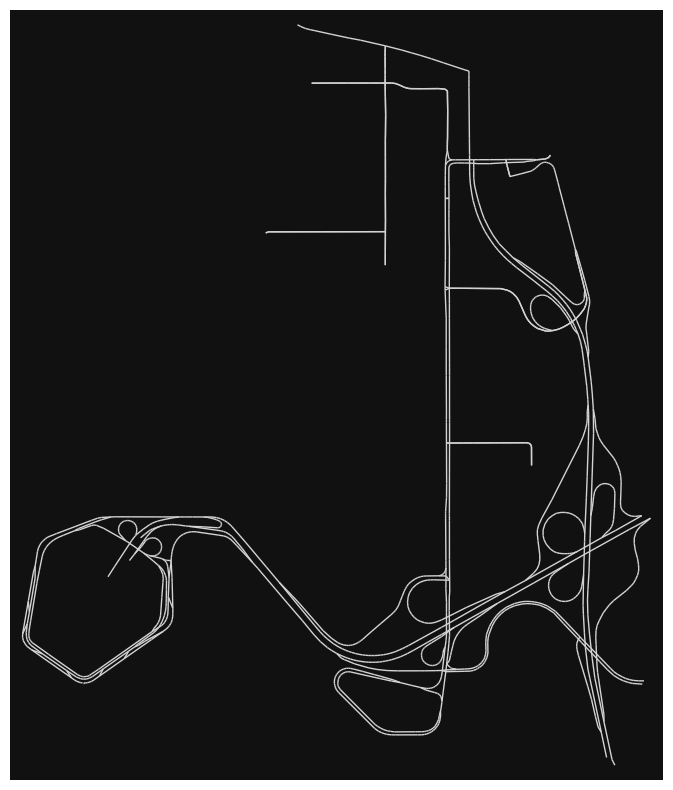

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [66]:
import osmnx as ox

G = ox.graph_from_place(
    "O'Hare, Chicago, Illinois, USA",
    network_type="drive",
    simplify=False,
    retain_all=False,
)
ox.plot_graph(G, figsize=(10, 10), edge_color="lightgray", node_size=0)

### 8) Função para o `ground truth`
Preparamos um carregador para o arquivo de referência (`ground_truth.parquet`), que lista as arestas reais da trajetória.

In [67]:
def load_ground_truth(path: Path) -> pd.DataFrame:
    df = duckdb.query(
        f"""                
        SELECT DISTINCT edge_id
        FROM '{path}'
        WHERE vehicle_id = {VEHICLE_ID}
        ORDER BY time ASC
        """
    ).to_df()

    return df

### 9) Ler o `ground truth`
Abrimos o dataset de referência para comparar com a rota estimada.

In [68]:
ground_truth_df = load_ground_truth(DATA_PATH / "ground_truth.parquet")
ground_truth_df

,edge_id
0,12253304
1,12253244
2,28257291
3,1207996115
4,28257292
5,12252996
6,1047786713
7,1047786712
8,474544200
9,1426387812


### 10) Extrair sequência de arestas
Convertendo o DataFrame de verdade-terreno em uma lista de `edge_id`, deixamos pronto para a sobreposição no gráfico.

In [69]:
ground_truth = ground_truth_df["edge_id"].tolist()
ground_truth[:5]

['12253304', '12253244', '28257291', '1207996115', '28257292']

### 11) Visualizar comparação
Plotamos a rota estimada sobre o grafo e destacamos as arestas da verdade-terreno para inspeção visual do ajuste.

In [70]:
result.plot_on_graph(
    graph=G,
    ground_truth_edge_ids=ground_truth,
)